In [2]:
# Description: CogSci paper analysis for Experiment 1
# Python version: 3.11.2 
# Date: 2023-05-12

# Load libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

In [3]:
# Load data
trials_PEC_path = '../outputs/all_trials_with_Ri.csv'
trials_PEC = pd.read_csv(trials_PEC_path)

# select only Experiment 1 data
trials_PEC = trials_PEC[trials_PEC['learning_condition'] == 'Experiment 1 (no preview)']

# aggregate accuracy data for each participant and each trial type response_correct and response_correct_mm
aggregated_accuracy = trials_PEC.groupby(['participant_id', 'learning_condition', 'fsm_type', 'test_condition', 'trial_type'])['response_correct', 'response_correct_mm'].mean().reset_index()

# create trials_PEC_long dataframe
trials_PEC_long = pd.melt(aggregated_accuracy, id_vars=['participant_id', 'learning_condition', 'fsm_type', 'test_condition', 'trial_type'],
                            value_vars=['response_correct', 'response_correct_mm'], var_name='accuracy_type', value_name='accuracy')

# aggregate accuracy data for each participant and each trial type
aggregated_accuracy = trials_PEC_long 

/var/folders/l7/9hgxx_dj03s7tlk60qhh11yc0000gn/T/ipykernel_53531/400885782.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  aggregated_accuracy = trials_PEC.groupby(['participant_id', 'learning_condition', 'fsm_type', 'test_condition', 'trial_type'])['response_correct', 'response_correct_mm'].mean().reset_index()


Text(0.5, 1.0, '')

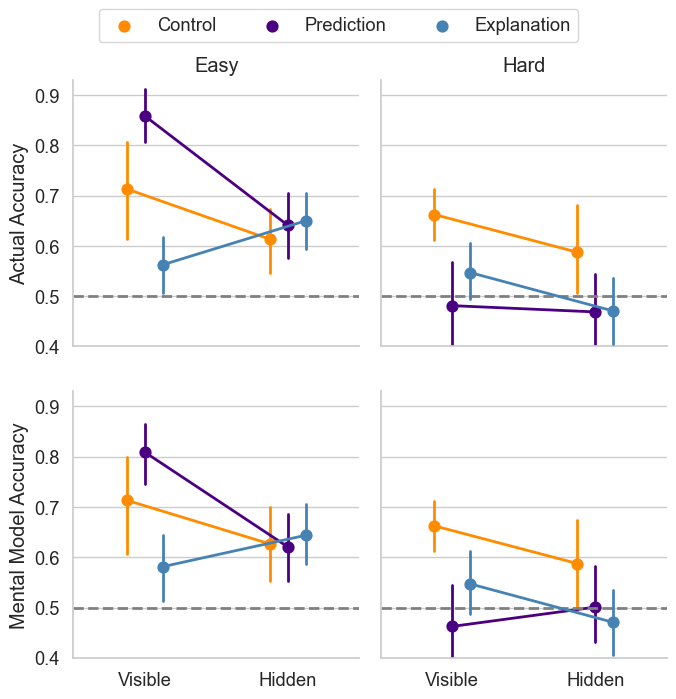

In [4]:
# rename easy to Easy and hard to Hard
aggregated_accuracy['fsm_type'] = aggregated_accuracy['fsm_type'].replace({'easy': 'Easy', 'hard': 'Hard'})

# rename test_condition 
aggregated_accuracy['test_condition'] = aggregated_accuracy['test_condition'].replace({'prediction': 'Prediction', 'control': 'Control', 'explanation': 'Explanation'})
aggregated_accuracy['trial_type'] = aggregated_accuracy['trial_type'].replace({'visible': 'Visible', 'hidden': 'Hidden'})

# convert trial_type and fsm_type to categorical variable with ordered levels
aggregated_accuracy['trial_type'] = pd.Categorical(aggregated_accuracy['trial_type'], categories=['Visible', 'Hidden'], ordered=True)
aggregated_accuracy['fsm_type'] = pd.Categorical(aggregated_accuracy['fsm_type'], categories=['Easy', 'Hard'], ordered=True)

# Plot mean accuracy and 95%CI
sns.set(style="whitegrid", font_scale=1.2) # set style and font size for all plots

g = sns.catplot(x="trial_type", y="accuracy", hue="test_condition", col="fsm_type", row="accuracy_type", data=aggregated_accuracy,
                kind="point", dodge=0.25, join=True, errorbar = ("ci", 95), palette=['darkorange','indigo','steelblue'],
                height=3.5, aspect=1, legend=False) # set legend to False

# make line thiner
for ax in g.axes.flat:
    ax.set_ylim(0.4, 0.93)
    ax.axhline(0.5, ls='--', color='gray')
    for line in ax.lines:
        line.set_linewidth(2)
    
# add different y-axis labels for each row (Actual vs. Mental Model)
g.axes[0,0].set_ylabel("Actual Accuracy")
g.axes[1,0].set_ylabel("Mental Model Accuracy")

# remove x-axis label
g.set_xlabels("")

# add legend to the top center outside of the plot and in 3 rows
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))

# add col names to the top of each column
g.axes[0,0].set_title("Easy")
g.axes[0,1].set_title("Hard")
g.axes[1,0].set_title("")
g.axes[1,1].set_title("")

In [5]:
# Evaluate the difference between MM and actual accuracy with a paired t-test (for participants)
from scipy import stats

# select only actual accuracy
actual_accuracy = aggregated_accuracy[aggregated_accuracy['accuracy_type'] == 'response_correct']

# select only mental model accuracy
mental_model_accuracy = aggregated_accuracy[aggregated_accuracy['accuracy_type'] == 'response_correct_mm']

# make sure that the order of the rows is the same for both dataframes
actual_accuracy = actual_accuracy.sort_values(by=['participant_id', 'learning_condition', 'fsm_type', 'test_condition', 'trial_type'])
mental_model_accuracy = mental_model_accuracy.sort_values(by=['participant_id', 'learning_condition', 'fsm_type', 'test_condition', 'trial_type'])

# check if participant order is the same in both dataframes
np.array_equal(actual_accuracy['participant_id'], mental_model_accuracy['participant_id'])

# run paired t-test
stats.ttest_rel(actual_accuracy['accuracy'], mental_model_accuracy['accuracy'])

# round t to 2 decimal places and p to 3 decimal places
print('t = ' + str(round(stats.ttest_rel(actual_accuracy['accuracy'], mental_model_accuracy['accuracy'])[0], 3)))
print('p = ' + str(round(stats.ttest_rel(actual_accuracy['accuracy'], mental_model_accuracy['accuracy'])[1], 4)))
print(stats.ttest_rel(actual_accuracy['accuracy'], mental_model_accuracy['accuracy']))

# means and standard deviations + number of trials and round float to 2 decimal places
aggregated_accuracy.groupby(['accuracy_type'])['accuracy'].agg(['mean', 'std', 'count']).round(2)

t = 0.899
p = 0.37
TtestResult(statistic=0.8985656572346041, pvalue=0.37000370689599726, df=193)


,mean,std,count
accuracy_type,,,
response_correct,0.6,0.18,194
response_correct_mm,0.6,0.18,194


In [6]:
# run one-sample t-test to check if actual accuracy is significantly different from chance level (0.5) for each test condition, FSM type, and trial type
# select only actual accuracy
actual_accuracy = aggregated_accuracy[aggregated_accuracy['accuracy_type'] == 'response_correct_mm']

# run one-sample t-test for each test condition, FSM type, and trial type
for test_condition in actual_accuracy['test_condition'].unique():
    for fsm_type in actual_accuracy['fsm_type'].unique():
        for trial_type in actual_accuracy['trial_type'].unique():
            results = stats.ttest_1samp(actual_accuracy[(actual_accuracy['test_condition'] == test_condition) & 
                                                    (actual_accuracy['fsm_type'] == fsm_type) & 
                                                    (actual_accuracy['trial_type'] == trial_type)]['accuracy'], popmean = 0.5, alternative='greater')
            print(test_condition + ' ' + fsm_type + ' ' + trial_type + ': t = ' + str(round(results[0], 2)) + '. p = ' + str(round(results[1], 3)))
            print(results) 


Control Hard Hidden: t = 1.92. p = 0.037
TtestResult(statistic=1.9218395710057121, pvalue=0.0369160400682597, df=15)
Control Hard Visible: t = 6.34. p = 0.0
TtestResult(statistic=6.343350474165464, pvalue=6.595141519419105e-06, df=15)
Control Easy Hidden: t = 3.2. p = 0.003
TtestResult(statistic=3.198557367121812, pvalue=0.0032194942429429442, df=14)
Control Easy Visible: t = 4.07. p = 0.001
TtestResult(statistic=4.068694202974834, pvalue=0.0005752014085579291, df=14)
Prediction Hard Hidden: t = 0.02. p = 0.492
TtestResult(statistic=0.02071410288142934, pvalue=0.49187337611599413, df=15)
Prediction Hard Visible: t = -0.82. p = 0.788
TtestResult(statistic=-0.8236455304310201, pvalue=0.7884780498086879, df=15)
Prediction Easy Hidden: t = 3.22. p = 0.003
TtestResult(statistic=3.220620698238445, pvalue=0.002670547647798034, df=16)
Prediction Easy Visible: t = 9.56. p = 0.0
TtestResult(statistic=9.563120447814205, pvalue=2.5476942219403012e-08, df=16)
Explanation Hard Hidden: t = -0.89. p =

In [7]:
# run pairwise t-tests to check if mental model accuracy is different between prediction, explanation and control for each FSM type and trial type (use Bonferroni correction)
import pingouin as pg

mental_model_accuracy = aggregated_accuracy[aggregated_accuracy['accuracy_type'] == 'response_correct_mm']

results = pd.DataFrame()
for fsm_type in mental_model_accuracy['fsm_type'].unique():
    subset = mental_model_accuracy[(mental_model_accuracy['fsm_type'] == fsm_type)].dropna() 
    results_current = pg.pairwise_tests(dv='accuracy', within='trial_type', subject='participant_id', between='test_condition', data=subset, padjust='fdr_bh', effsize='cohen', return_desc=True)
    results_current['fsm_type'] = fsm_type
    results = results.append(results_current)

results

/Users/roman/Library/CloudStorage/GoogleDrive-roman.tikhonov1@gmail.com/My Drive/1 PROJECTS/cogsci-2023/osf_upload/.venv/lib/python3.11/site-packages/pingouin/pairwise.py:478: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = data.groupby([subject, f], as_index=False, observed=True, sort=True).mean()
/Users/roman/Library/CloudStorage/GoogleDrive-roman.tikhonov1@gmail.com/My Drive/1 PROJECTS/cogsci-2023/osf_upload/.venv/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Users/roman/Library/CloudStorage/GoogleDrive-roman.tikhonov1@gmail.com/My Drive/1 PROJECTS/cogsci-2023/osf_upload/.venv/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow 

,Contrast,trial_type,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen,fsm_type
0,trial_type,-,Hidden,Visible,0.518659,0.168254,0.557143,0.162019,True,True,-1.449620,48.000000,two-sided,0.153667,NaN,NaN,0.413,-0.233002,Hard
1,test_condition,-,Control,Explanation,0.625000,0.103280,0.508824,0.104933,False,True,3.204488,30.932520,two-sided,0.003133,0.007269,fdr_bh,12.419,1.115618,Hard
2,test_condition,-,Control,Prediction,0.625000,0.103280,0.481696,0.157596,False,True,3.042169,30.000000,two-sided,0.004846,0.007269,fdr_bh,8.821,1.075569,Hard
3,test_condition,-,Explanation,Prediction,0.508824,0.104933,0.481696,0.157596,False,True,0.578353,25.901642,two-sided,0.568021,0.568021,fdr_bh,0.378,0.203895,Hard
4,trial_type * test_condition,Hidden,Control,Explanation,0.587500,0.182117,0.470588,0.135852,False,True,2.080242,27.702523,two-sided,0.046874,0.093747,fdr_bh,1.664,0.731070,Hard
5,trial_type * test_condition,Hidden,Control,Prediction,0.587500,0.182117,0.500893,0.172415,False,True,1.381370,30.000000,two-sided,0.177368,0.212841,fdr_bh,0.692,0.488388,Hard
6,trial_type * test_condition,Hidden,Explanation,Prediction,0.470588,0.135852,0.500893,0.172415,False,True,-0.558561,28.521623,two-sided,0.580820,0.580820,fdr_bh,0.375,-0.195985,Hard
7,trial_type * test_condition,Visible,Control,Explanation,0.662500,0.102470,0.547059,0.132842,False,True,2.804555,29.884613,two-sided,0.008771,0.026313,fdr_bh,5.654,0.969143,Hard
8,trial_type * test_condition,Visible,Control,Prediction,0.662500,0.102470,0.462500,0.182117,False,True,3.828379,30.000000,two-sided,0.000611,0.003664,fdr_bh,46.392,1.353537,Hard
9,trial_type * test_condition,Visible,Explanation,Prediction,0.547059,0.132842,0.462500,0.182117,False,True,1.516039,27.353900,two-sided,0.140982,0.211473,fdr_bh,0.795,0.533130,Hard


In [8]:
df = trials_PEC.copy()

# rename R_i_mm_eps_0.1 column to R_i_mm_eps_0_1
df = df.rename(columns={'R_i_mm_eps_0.1': 'R_i_mm_eps_0_1'})

df['participant_id'] = df['participant_id'].astype('category')
df['trial_type'] = pd.Categorical(df['trial_type'], categories=["visible", "hidden"], ordered=False)

df_p_easy = df[(df['test_condition'] == "prediction") & (df['fsm_type'] == "easy")]
df_c_easy = df[(df['test_condition'] == "control") & (df['fsm_type'] == "easy")]
df_e_easy = df[(df['test_condition'] == "explanation") & (df['fsm_type'] == "easy")]

df_p_hard = df[(df['test_condition'] == "prediction") & (df['fsm_type'] == "hard")]
df_c_hard = df[(df['test_condition'] == "control") & (df['fsm_type'] == "hard")]
df_e_hard = df[(df['test_condition'] == "explanation") & (df['fsm_type'] == "hard")]

dfs = {"df_p_easy": df_p_easy, "df_c_easy": df_c_easy, "df_e_easy": df_e_easy, 
       "df_p_hard": df_p_hard, "df_c_hard": df_c_hard, "df_e_hard": df_e_hard}

glms = {}

for name, dataset in dfs.items():
    md = smf.glm('response_correct_mm ~ 0 + R_i_mm_eps_0_1 * trial_type - trial_type', 
                  data = dataset, 
                  family = sm.families.Binomial()).fit()
        
    print(md.summary())
    glms[name] = md

                  Generalized Linear Model Regression Results                  
Dep. Variable:     response_correct_mm   No. Observations:                  323
Model:                             GLM   Df Residuals:                      321
Model Family:                 Binomial   Df Model:                            1
Link Function:                   Logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -171.78
Date:                 Fri, 12 May 2023   Deviance:                       343.56
Time:                         19:57:35   Pearson chi2:                     322.
No. Iterations:                      4   Pseudo R-squ. (CS):             0.1075
Covariance Type:             nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [45]:
glms['df_p_easy'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                  
===============================================================================
Dep. Variable:     response_correct_mm   No. Observations:                  323
Model:                             GLM   Df Residuals:                      321
Model Family:                 Binomial   Df Model:                            1
Link Function:                   Logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -171.78
Date:                 Fri, 12 May 2023   Deviance:                       343.56
Time:                         19:34:32   Pearson chi2:                     322.
No. Iterations:                      4   Pseudo R-squ. (CS):             0.1075
Covariance Type:             nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
R_i_mm_eps_0_1                          0.8993      0.117      7.688      0.000       0.670       1.129
R_i_mm_eps_0_1:trial_type[T.hidden]    -0.5061      0.163     -3.102      0.002      -0.826      -0.186
=======================================================================================================
"""

glms['df_c_easy'].summary()

In [51]:
glms['df_c_easy'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                  
===============================================================================
Dep. Variable:     response_correct_mm   No. Observations:                  300
Model:                             GLM   Df Residuals:                      298
Model Family:                 Binomial   Df Model:                            1
Link Function:                   Logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -189.90
Date:                 Fri, 12 May 2023   Deviance:                       379.79
Time:                         19:35:34   Pearson chi2:                     300.
No. Iterations:                      4   Pseudo R-squ. (CS):           0.002375
Covariance Type:             nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
R_i_mm_eps_0_1                          0.4801      0.091      5.256      0.000       0.301       0.659
R_i_mm_eps_0_1:trial_type[T.hidden]    -0.2730      0.134     -2.039      0.041      -0.535      -0.011
=======================================================================================================
"""

In [50]:
glms['df_e_easy'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                  
===============================================================================
Dep. Variable:     response_correct_mm   No. Observations:                  320
Model:                             GLM   Df Residuals:                      318
Model Family:                 Binomial   Df Model:                            1
Link Function:                   Logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -212.47
Date:                 Fri, 12 May 2023   Deviance:                       424.93
Time:                         19:35:33   Pearson chi2:                     320.
No. Iterations:                      4   Pseudo R-squ. (CS):           0.007293
Covariance Type:             nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
R_i_mm_eps_0_1                          0.1804      0.086      2.101      0.036       0.012       0.349
R_i_mm_eps_0_1:trial_type[T.hidden]     0.1682      0.128      1.313      0.189      -0.083       0.419
=======================================================================================================
"""

In [47]:
glms['df_p_hard'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                  
===============================================================================
Dep. Variable:     response_correct_mm   No. Observations:                  317
Model:                             GLM   Df Residuals:                      315
Model Family:                 Binomial   Df Model:                            1
Link Function:                   Logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -219.15
Date:                 Fri, 12 May 2023   Deviance:                       438.31
Time:                         19:34:32   Pearson chi2:                     317.
No. Iterations:                      4   Pseudo R-squ. (CS):           0.001938
Covariance Type:             nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
R_i_mm_eps_0_1                         -0.0555      0.081     -0.683      0.494      -0.215       0.104
R_i_mm_eps_0_1:trial_type[T.hidden]     0.1386      0.130      1.070      0.285      -0.115       0.393
=======================================================================================================
"""

In [48]:
glms['df_c_hard'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                  
===============================================================================
Dep. Variable:     response_correct_mm   No. Observations:                  320
Model:                             GLM   Df Residuals:                      318
Model Family:                 Binomial   Df Model:                            1
Link Function:                   Logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -209.42
Date:                 Fri, 12 May 2023   Deviance:                       418.84
Time:                         19:34:32   Pearson chi2:                     320.
No. Iterations:                      4   Pseudo R-squ. (CS):            0.01415
Covariance Type:             nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
R_i_mm_eps_0_1                          0.3997      0.091      4.398      0.000       0.222       0.578
R_i_mm_eps_0_1:trial_type[T.hidden]    -0.1964      0.139     -1.417      0.156      -0.468       0.075
=======================================================================================================
"""

In [49]:
glms['df_e_hard'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                  
===============================================================================
Dep. Variable:     response_correct_mm   No. Observations:                  340
Model:                             GLM   Df Residuals:                      338
Model Family:                 Binomial   Df Model:                            1
Link Function:                   Logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -233.98
Date:                 Fri, 12 May 2023   Deviance:                       467.96
Time:                         19:34:32   Pearson chi2:                     340.
No. Iterations:                      4   Pseudo R-squ. (CS):           0.009589
Covariance Type:             nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
R_i_mm_eps_0_1                          0.1848      0.101      1.826      0.068      -0.014       0.383
R_i_mm_eps_0_1:trial_type[T.hidden]    -0.1944      0.148     -1.317      0.188      -0.484       0.095
=======================================================================================================
"""